## Import libraries and load data

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch

In [2]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [2]:
out = np.load('disc-benchmark-files/training-data.npz')
th_train = out['th'] #th[0],th[1],th[2],th[3],...
u_train = out['u'] #u[0],u[1],u[2],u[3],...

data = np.load('disc-benchmark-files/test-simulation-submission-file.npz')
u_test = data['u']
th_test = data['th'] #only the first 50 values are filled the rest are zeros

## Visualize data

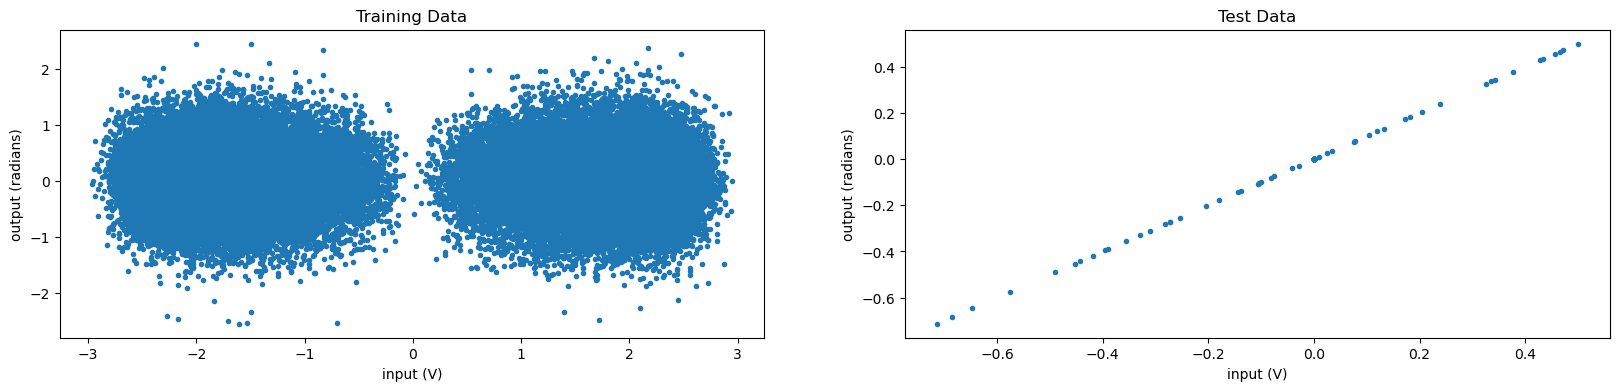

In [4]:
# Plotting the data
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.plot(u_train,th_train,'.')
plt.xlabel('input (V)')
plt.ylabel('output (radians)')
plt.title('Training Data')
plt.subplot(1,2,2)
plt.plot(th_test,th_test,'.')
plt.xlabel('input (V)')
plt.ylabel('output (radians)')
plt.title('Test Data')
plt.show()

## 1. ANN

In [3]:
def create_IO_data(u,y,na,nb):
    X = []
    Y = []
    for k in range(max(na,nb), len(y)):
        X.append(np.concatenate([u[k-nb:k],y[k-na:k]]))
        Y.append(y[k])
    return np.array(X), np.array(Y)

In [6]:


'''Linear net with 2 hidden layer'''
class NARX_NN(nn.Module):
    def __init__(self,in_,hidden_1,hidden_2):
        super(NARX_NN, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_,hidden_1, bias=True, dtype=torch.float32),
            nn.ReLU(True),
            nn.Linear(hidden_1, hidden_2, bias=True, dtype=torch.float32),
            nn.ReLU(True),
            nn.Linear(hidden_2, 1, bias=True, dtype=torch.float32)
        )

    def forward(self,x):
        u = self.layer(x)[:,0]
        return u
        
def train(model,optimizer,criterion,epochs,Xtrain,Ytrain,Xval,Yval):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.train()
    train_loss = []
    val_loss =[]
    for _ in range(epochs):
        Ypred = model(Xtrain.to(device=device))
        loss_train = criterion(Ypred.to(device=device),Ytrain.to(device=device))
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        train_loss.append(loss_train.item())

        with torch.no_grad():
            model.eval()
            Ypred = model(Xval.to(device=device))
            loss_val = criterion(Ypred.to(device=device), Yval)
            val_loss.append(loss_val.item())

        # if (epoch+1)%200 == 0:
        #     print(f'epoch = {epoch+1}, Train_loss = {loss_train.item(): .4f}, Val_loss = {loss_val.item(): .4f}')
    return train_loss, val_loss 

In [7]:
Xdata, Ydata = create_IO_data(u_train,th_train,2,1) # For training data
Xtest, Ytest = create_IO_data(u_test, th_test, 2,1)    # For simulation data

Xtrain, Xval, Ytrain, Yval = train_test_split(Xdata,Ydata)
device="cuda" if torch.cuda.is_available() else "cpu"
Xtrain,Xval,Ytrain,Yval = [torch.as_tensor(x).to(device=device, dtype=torch.float32) for x in [Xtrain, Xval, Ytrain, Yval]]
Xtest, Ytest = [torch.as_tensor(x).to(device=device) for x in [Xtest, Ytest]]

model = NARX_NN(Xtrain.shape[1],32,16).to(device=device)
learning_rate = 2e-3
optimizer, criterion = torch.optim.Adam(model.parameters(), lr=learning_rate), nn.MSELoss()
train_loss, val_loss = train(model, optimizer, criterion, 500, Xtrain, Ytrain, Xval, Yval)
torch.save(model.state_dict(), "ann.pth")    # Saving the best model

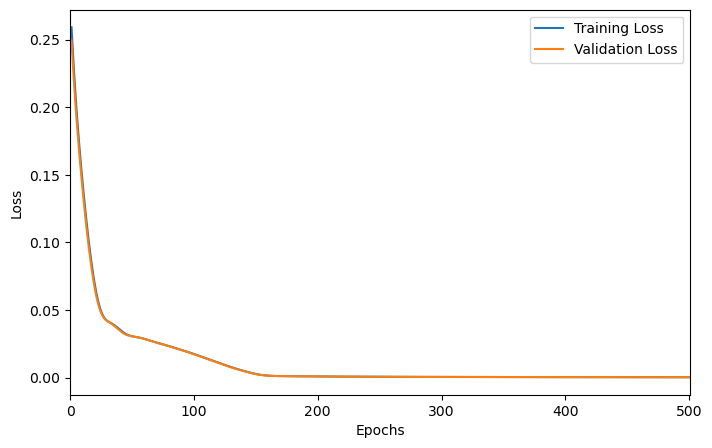

In [8]:
# Plotting the training and validation loss
plt.figure(figsize=(8,5)) 
plt.plot(np.linspace(1,500,num=500), train_loss, label="Training Loss") 
plt.plot(np.linspace(1,500,num=500), val_loss, label="Validation Loss") 
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.xlim(left=0, right=501)
plt.show() 

In [17]:
'''na = 6, nb = 10'''
'''GP kernel: RBF(function) and White(noise)'''
from sklearn.base import clone
from sklearn.model_selection import train_test_split
# from skopt import gp_minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared
import joblib
na = 6
nb = 10
Xdata, Ydata = create_IO_data(u_train, th_train, na, nb)

Xtest, Ytest = create_IO_data(u_test, th_test, na, nb)

Xtrain,Xval,Ytrain,Yval = train_test_split(Xdata[1:10000],Ydata[1:10000])


# Xtrain,Xval,Ytrain,Yval = train_test_split(Xdata,Ydata)

ker = RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)
reg = GaussianProcessRegressor(ker, n_restarts_optimizer=2) 
reg.fit(Xtrain,Ytrain)
joblib.dump(reg, "gp_ExpSine.pkl") # saving GP regression model


['gp_ExpSine.pkl']

In [15]:
from sklearn.base import clone
from sklearn.model_selection import train_test_split
# from skopt import gp_minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import joblib
# Loading GP regression model
reg = joblib.load("gp_ExpSine.pkl")

In [18]:
Xtrain_sample,Xval_sample,Ytrain_sample,Yval_sample = Xtrain[:5000,:],Xval[:1000,:],Ytrain[:5000],Yval[:1000]        
Xtest, Ytest = create_IO_data(u_test, th_test, na, nb)


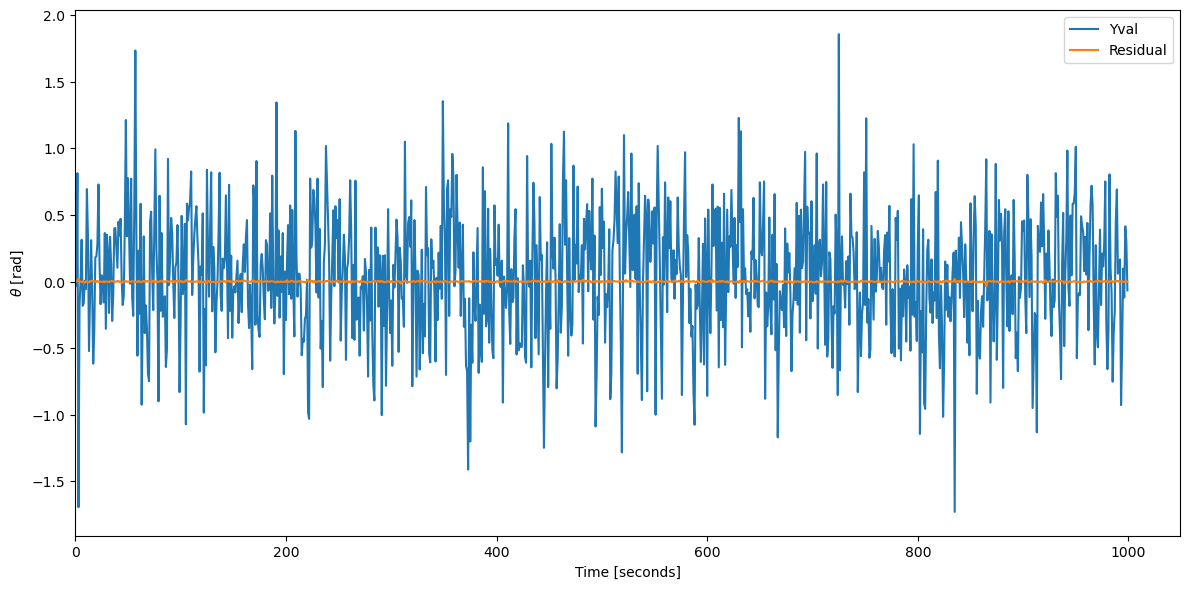

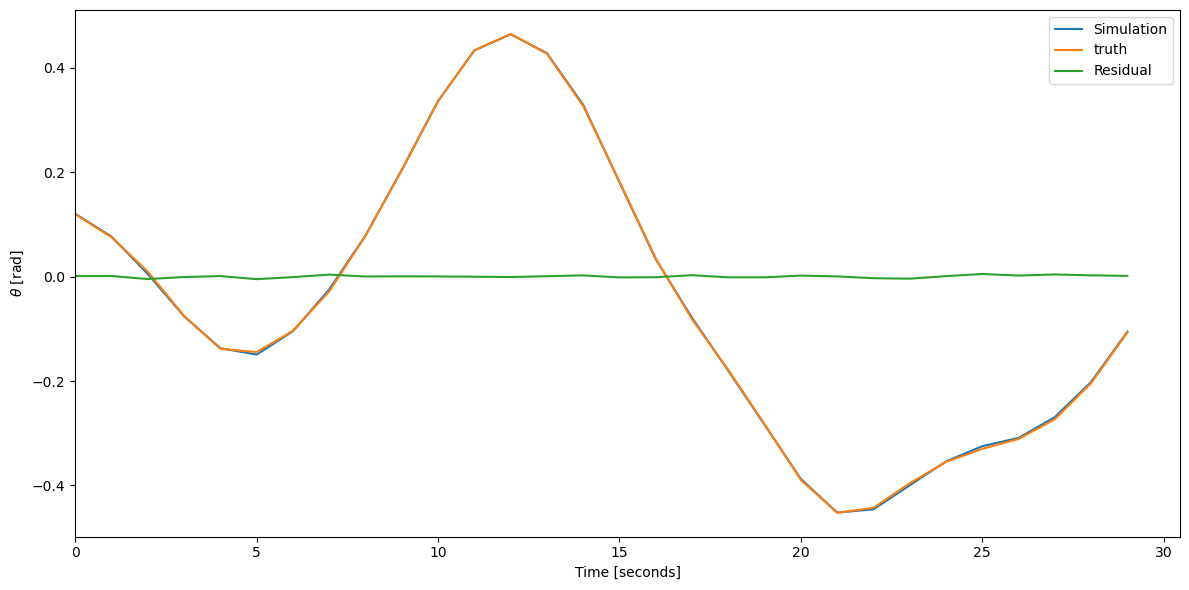

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [32]:
from IPython.display import display, Latex
%matplotlib inline


Yval_p, Yval_p_std = reg.predict(Xval_sample,return_std=True)
Ysim, Ysim_std = reg.predict(Xtest, return_std=True)

res = Yval_p-Yval_sample
plt.figure(figsize=(12,6))
plt.plot(Yval_sample,label='Yval')
plt.plot(res,label='Residual')
plt.xlabel("Time [seconds]"); plt.ylabel(r"$\theta$ [rad]")
plt.xlim(left=0)
plt.legend()
plt.tight_layout()
plt.show()

simres = Ysim[max(na,nb):40] - Ytest[max(na,nb):40]
plt.figure(figsize=(12,6))
plt.plot(Ysim[max(na,nb):40],label='Simulation')
plt.plot(Ytest[max(na,nb):40],label='truth')
plt.plot(simres,label='Residual')
plt.xlabel("Time [seconds]"); plt.ylabel(r"$\theta$ [rad]")
plt.xlim(left=0)
plt.legend()
plt.tight_layout()
plt.show()

display(Latex(f"Marginal log-likelihood = {reg.log_marginal_likelihood(): .4f} || $R^2$ = {reg.score(Xtest, Ytest): .4f}"))
display(Latex(f'Validation RMS = {np.mean((res**2))**0.5: .4f} || NRMS = {np.mean((res**2))**0.5/np.std(Yval_sample): .4f}'))
display(Latex(f'Simulation RMS = {np.mean((simres**2))**0.5: .4f} || NRMS = {np.mean((simres**2))**0.5/np.std(Ytest[max(na,nb):40]): .4f}'))